# SmolLM2-135M Training from Scratch

This notebook implements the SmolLM2-135M architecture (Llama-based) and trains it from scratch.

## Model Architecture
- **Model Type**: LlamaForCausalLM (decoder-only transformer)
- **Parameters**: ~134.5M
- **Key Features**: RMSNorm, RoPE, Grouped Query Attention (GQA), SwiGLU MLP

## Training Plan
- Train for 5000 steps with checkpointing every 500 steps
- Generate text with fixed prompts every 500 steps
- Stop and resume from checkpoint for 50 more steps

## 1. Setup and Imports

In [1]:
!pip install tiktoken

In [2]:
import os
import math
import time
from dataclasses import dataclass
from typing import Optional, Tuple

import torch
import torch.nn as nn
from torch.nn import functional as F
import tiktoken

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.0+cu126
CUDA available: True
CUDA device: NVIDIA A100-SXM4-40GB


## 2. Model Configuration

SmolLM2-135M configuration from official training recipe.

In [3]:
@dataclass
class SmolLM2Config:
    """SmolLM2-135M Configuration"""
    vocab_size: int = 50304
    hidden_size: int = 576
    intermediate_size: int = 1536
    num_hidden_layers: int = 30
    num_attention_heads: int = 9
    num_key_value_heads: int = 3
    max_position_embeddings: int = 2048
    rms_norm_eps: float = 1e-5
    rope_theta: float = 10000.0
    hidden_act: str = "silu"
    initializer_range: float = 0.041666666666666664
    tie_word_embeddings: bool = True
    bos_token_id: int = 0
    eos_token_id: int = 0

    @property
    def head_dim(self) -> int:
        return self.hidden_size // self.num_attention_heads

## 3. Model Architecture Components

### 3.1 RMSNorm (Root Mean Square Layer Normalization)

In [4]:
class RMSNorm(nn.Module):
    """Root Mean Square Layer Normalization

    Unlike LayerNorm, RMSNorm doesn't center the activations (no mean subtraction).
    This makes it more efficient while maintaining similar performance.

    Formula: x * weight / sqrt(mean(x^2) + eps)
    """
    def __init__(self, hidden_size: int, eps: float = 1e-5):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.eps = eps

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Calculate RMS
        rms = torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
        return x * rms * self.weight

### 3.2 Rotary Position Embedding (RoPE)

In [5]:
class RotaryEmbedding(nn.Module):
    """Rotary Position Embedding (RoPE)

    RoPE encodes position information by rotating the query and key vectors.
    This allows the model to learn relative positions naturally.

    Key insight: The dot product of rotated vectors depends on their relative position.
    """
    def __init__(self, dim: int, max_position_embeddings: int = 2048, theta: float = 10000.0):
        super().__init__()
        self.dim = dim
        self.max_position_embeddings = max_position_embeddings
        self.theta = theta

        # Compute inverse frequencies
        inv_freq = 1.0 / (self.theta ** (torch.arange(0, self.dim, 2, dtype=torch.float32) / self.dim))
        self.register_buffer("inv_freq", inv_freq, persistent=False)

        # Precompute cos and sin cache
        self._set_cos_sin_cache(max_position_embeddings)

    def _set_cos_sin_cache(self, seq_len: int):
        self.max_seq_len_cached = seq_len
        t = torch.arange(seq_len, dtype=torch.float32)
        freqs = torch.outer(t, self.inv_freq)
        emb = torch.cat((freqs, freqs), dim=-1)
        self.register_buffer("cos_cached", emb.cos(), persistent=False)
        self.register_buffer("sin_cached", emb.sin(), persistent=False)

    def forward(self, x: torch.Tensor, seq_len: int) -> Tuple[torch.Tensor, torch.Tensor]:
        if seq_len > self.max_seq_len_cached:
            self._set_cos_sin_cache(seq_len)
        return (
            self.cos_cached[:seq_len].to(x.dtype),
            self.sin_cached[:seq_len].to(x.dtype)
        )


def rotate_half(x: torch.Tensor) -> torch.Tensor:
    """Rotate half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)


def apply_rotary_pos_emb(q: torch.Tensor, k: torch.Tensor, cos: torch.Tensor, sin: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    """Apply rotary position embedding to query and key tensors."""
    # cos, sin: [seq_len, dim] -> [1, 1, seq_len, dim]
    cos = cos.unsqueeze(0).unsqueeze(0)
    sin = sin.unsqueeze(0).unsqueeze(0)

    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

### 3.3 Grouped Query Attention (GQA)

In [6]:
class GroupedQueryAttention(nn.Module):
    """Grouped Query Attention (GQA)

    GQA is a memory-efficient attention variant where multiple query heads
    share the same key-value heads. SmolLM2-135M uses 9 query heads with 3 KV heads,
    so each KV head is shared by 3 query heads.

    Benefits:
    - Reduces memory bandwidth during inference (smaller KV cache)
    - Maintains model quality compared to full MHA
    """
    def __init__(self, config: SmolLM2Config):
        super().__init__()
        self.config = config
        self.hidden_size = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.num_kv_heads = config.num_key_value_heads
        self.head_dim = config.head_dim
        self.num_kv_groups = self.num_heads // self.num_kv_heads  # 9 // 3 = 3

        # Q projection: hidden_size -> num_heads * head_dim
        self.q_proj = nn.Linear(self.hidden_size, self.num_heads * self.head_dim, bias=False)
        # K, V projections: hidden_size -> num_kv_heads * head_dim
        self.k_proj = nn.Linear(self.hidden_size, self.num_kv_heads * self.head_dim, bias=False)
        self.v_proj = nn.Linear(self.hidden_size, self.num_kv_heads * self.head_dim, bias=False)
        # Output projection
        self.o_proj = nn.Linear(self.num_heads * self.head_dim, self.hidden_size, bias=False)

        # Rotary embeddings
        self.rotary_emb = RotaryEmbedding(
            self.head_dim,
            max_position_embeddings=config.max_position_embeddings,
            theta=config.rope_theta
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, T, C = x.size()

        # Project to Q, K, V
        q = self.q_proj(x)  # (B, T, num_heads * head_dim)
        k = self.k_proj(x)  # (B, T, num_kv_heads * head_dim)
        v = self.v_proj(x)  # (B, T, num_kv_heads * head_dim)

        # Reshape for multi-head attention
        q = q.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)  # (B, num_heads, T, head_dim)
        k = k.view(B, T, self.num_kv_heads, self.head_dim).transpose(1, 2)  # (B, num_kv_heads, T, head_dim)
        v = v.view(B, T, self.num_kv_heads, self.head_dim).transpose(1, 2)  # (B, num_kv_heads, T, head_dim)

        # Apply rotary position embeddings
        cos, sin = self.rotary_emb(x, T)
        q, k = apply_rotary_pos_emb(q, k, cos, sin)

        # Repeat K, V for grouped query attention
        # Each KV head is used by num_kv_groups query heads
        k = k.repeat_interleave(self.num_kv_groups, dim=1)  # (B, num_heads, T, head_dim)
        v = v.repeat_interleave(self.num_kv_groups, dim=1)  # (B, num_heads, T, head_dim)

        # Flash Attention using scaled_dot_product_attention
        y = F.scaled_dot_product_attention(q, k, v, is_causal=True)

        # Reshape back
        y = y.transpose(1, 2).contiguous().view(B, T, self.hidden_size)

        # Output projection
        y = self.o_proj(y)
        return y

### 3.4 SwiGLU MLP

In [7]:
class SwiGLUMLP(nn.Module):
    """SwiGLU Feed-Forward Network

    SwiGLU is a variant of GLU (Gated Linear Unit) that uses SiLU activation.
    It has been shown to improve model quality over standard GELU MLPs.

    Formula: output = down_proj(silu(gate_proj(x)) * up_proj(x))

    Note: This uses 3 linear layers instead of 2, but intermediate_size is
    adjusted so total parameters are similar.
    """
    def __init__(self, config: SmolLM2Config):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.intermediate_size = config.intermediate_size

        # Three projections for SwiGLU
        self.gate_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=False)
        self.up_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=False)
        self.down_proj = nn.Linear(self.intermediate_size, self.hidden_size, bias=False)
        self.act_fn = nn.SiLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # SwiGLU: silu(gate) * up, then down
        return self.down_proj(self.act_fn(self.gate_proj(x)) * self.up_proj(x))

### 3.5 Transformer Block

In [8]:
class SmolLM2Block(nn.Module):
    """SmolLM2 Transformer Block

    Pre-norm architecture with:
    - RMSNorm before attention and MLP
    - Residual connections after attention and MLP
    """
    def __init__(self, config: SmolLM2Config):
        super().__init__()
        self.input_layernorm = RMSNorm(config.hidden_size, eps=config.rms_norm_eps)
        self.self_attn = GroupedQueryAttention(config)
        self.post_attention_layernorm = RMSNorm(config.hidden_size, eps=config.rms_norm_eps)
        self.mlp = SwiGLUMLP(config)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Pre-norm + Attention + Residual
        x = x + self.self_attn(self.input_layernorm(x))
        # Pre-norm + MLP + Residual
        x = x + self.mlp(self.post_attention_layernorm(x))
        return x

### 3.6 Complete SmolLM2 Model

In [9]:
class SmolLM2(nn.Module):
    """SmolLM2-135M: A Llama-based decoder-only transformer

    Architecture:
    - Token embeddings (no position embeddings - RoPE is applied in attention)
    - 30 transformer blocks with GQA and SwiGLU
    - Final RMSNorm
    - Language model head (tied with token embeddings)
    """
    def __init__(self, config: SmolLM2Config):
        super().__init__()
        self.config = config

        # Token embeddings (no position embeddings - using RoPE)
        self.embed_tokens = nn.Embedding(config.vocab_size, config.hidden_size)

        # Transformer blocks
        self.layers = nn.ModuleList([SmolLM2Block(config) for _ in range(config.num_hidden_layers)])

        # Final layer norm
        self.norm = RMSNorm(config.hidden_size, eps=config.rms_norm_eps)

        # Language model head
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)

        # Weight tying
        if config.tie_word_embeddings:
            self.lm_head.weight = self.embed_tokens.weight

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        """Initialize weights with the specified initializer range"""
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=self.config.initializer_range)

    def forward(self, input_ids: torch.Tensor, targets: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        B, T = input_ids.size()
        assert T <= self.config.max_position_embeddings, \
            f"Sequence length {T} exceeds max position embeddings {self.config.max_position_embeddings}"

        # Token embeddings
        x = self.embed_tokens(input_ids)

        # Forward through transformer blocks
        for layer in self.layers:
            x = layer(x)

        # Final norm and LM head
        x = self.norm(x)
        logits = self.lm_head(x)

        # Calculate loss if targets provided
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))

        return logits, loss

## 4. Parameter Count Verification

In [10]:
def count_parameters(model):
    """Count and display model parameters by component"""
    total = 0
    param_counts = {}

    for name, param in model.named_parameters():
        total += param.numel()

        # Group by component
        if 'embed_tokens' in name:
            key = 'Embedding'
        elif 'self_attn' in name:
            key = 'Attention'
        elif 'mlp' in name:
            key = 'MLP'
        elif 'norm' in name or 'layernorm' in name:
            key = 'Normalization'
        elif 'lm_head' in name:
            key = 'LM Head (tied)'
        else:
            key = 'Other'

        param_counts[key] = param_counts.get(key, 0) + param.numel()

    print("=" * 50)
    print("PARAMETER COUNT BY COMPONENT")
    print("=" * 50)
    for key, count in param_counts.items():
        print(f"{key:20s}: {count:>15,} ({count/1e6:.2f}M)")
    print("-" * 50)
    print(f"{'TOTAL':20s}: {total:>15,} ({total/1e6:.2f}M)")
    print("=" * 50)

    return total

# Create model and count parameters
config = SmolLM2Config()
model = SmolLM2(config)
total_params = count_parameters(model)

# Verify against expected ~134.5M
print(f"\nExpected: ~134,515,008 parameters")
print(f"Actual:   {total_params:,} parameters")
print(f"Match: {'Yes' if abs(total_params - 134515008) < 1000 else 'No'}")

PARAMETER COUNT BY COMPONENT
Embedding           :      28,975,104 (28.98M)
Normalization       :          35,136 (0.04M)
Attention           :      26,542,080 (26.54M)
MLP                 :      79,626,240 (79.63M)
--------------------------------------------------
TOTAL               :     135,178,560 (135.18M)

Expected: ~134,515,008 parameters
Actual:   135,178,560 parameters
Match: No


## 5. Data Loader

In [11]:
class DataLoaderLite:
    """Lightweight data loader for text tokenization and batching"""

    def __init__(self, B: int, T: int, data_path: str = 'input.txt'):
        """
        Args:
            B: Batch size
            T: Sequence length
            data_path: Path to text file
        """
        self.B = B
        self.T = T

        # Load and tokenize text
        with open(data_path, 'r', encoding='utf-8') as f:
            text = f.read()

        enc = tiktoken.get_encoding('gpt2')
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens)

        print(f'Loaded {len(self.tokens):,} tokens')
        print(f'1 epoch = {len(self.tokens) // (B * T):,} batches')

        self.current_position = 0

    def next_batch(self):
        """Get next batch of data"""
        B, T = self.B, self.T
        buf = self.tokens[self.current_position : self.current_position + B * T + 1]
        x = buf[:-1].view(B, T)  # Inputs
        y = buf[1:].view(B, T)   # Targets (shifted by 1)

        # Advance position
        self.current_position += B * T

        # Reset if at end of data
        if self.current_position + (B * T + 1) > len(self.tokens):
            self.current_position = 0

        return x, y

## 6. Text Generation

In [12]:
# Fixed prompts for consistent evaluation
FIXED_PROMPTS = [
    "Once upon a time",
    "The meaning of life is",
    "In a galaxy far away",
]

def generate_text(model, prompt: str, max_new_tokens: int = 50, temperature: float = 0.8, top_k: int = 50, device: str = 'cuda'):
    """Generate text from a prompt using the trained model"""
    model.eval()
    enc = tiktoken.get_encoding('gpt2')

    # Encode prompt
    tokens = enc.encode(prompt)
    tokens = torch.tensor(tokens, dtype=torch.long, device=device).unsqueeze(0)

    # Generate tokens
    with torch.no_grad():
        for _ in range(max_new_tokens):
            # Crop to max position embeddings
            idx_cond = tokens[:, -model.config.max_position_embeddings:]

            # Get predictions
            logits, _ = model(idx_cond)
            logits = logits[:, -1, :] / temperature

            # Top-k sampling
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = float('-inf')

            # Sample
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            tokens = torch.cat([tokens, next_token], dim=1)

    # Decode
    generated = enc.decode(tokens[0].tolist())
    model.train()
    return generated


def generate_samples(model, step: int, device: str = 'cuda'):
    """Generate samples from fixed prompts and print them"""
    print(f"\n{'='*60}")
    print(f"TEXT GENERATION AT STEP {step}")
    print(f"{'='*60}")

    for i, prompt in enumerate(FIXED_PROMPTS):
        generated = generate_text(model, prompt, max_new_tokens=50, device=device)
        print(f"\nPrompt {i+1}: '{prompt}'")
        print(f"Generated: {generated}")

    print(f"{'='*60}\n")

## 7. Training Configuration

In [13]:
# Device setup
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f"Using device: {device}")

# Set seeds for reproducibility
torch.manual_seed(1337)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)

# Speedup: TF32 precision
torch.set_float32_matmul_precision('high')

Using device: cuda


/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


In [14]:
# Training hyperparameters
max_steps = 5000  # Total training steps
checkpoint_interval = 500  # Checkpoint and generate every N steps

# Batch sizes
total_batch_size = 16  # Effective batch size
micro_batch_size = 4   # Actual batch size per forward pass
sequence_length = 1024  # Context window
gradient_accumulation_steps = total_batch_size // micro_batch_size

# Learning rate schedule (cosine with warmup)
max_lr = 6e-4
min_lr = max_lr * 0.1
warmup_steps = 500

# Optimizer
weight_decay = 0.1
grad_clip = 1.0

# Checkpoint directory
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

print(f"Training for {max_steps:,} steps")
print(f"Checkpoint interval: {checkpoint_interval} steps")
print(f"Effective batch size: {total_batch_size} (gradient accumulation: {gradient_accumulation_steps}x)")
print(f"Sequence length: {sequence_length}")
print(f"Learning rate: {min_lr:.2e} -> {max_lr:.2e} -> {min_lr:.2e}")

Training for 5,000 steps
Checkpoint interval: 500 steps
Effective batch size: 16 (gradient accumulation: 4x)
Sequence length: 1024
Learning rate: 6.00e-05 -> 6.00e-04 -> 6.00e-05


In [15]:
def get_lr(step: int) -> float:
    """Cosine learning rate schedule with warmup"""
    # Warmup
    if step < warmup_steps:
        return max_lr * (step + 1) / warmup_steps
    # Cosine decay
    if step > max_steps:
        return min_lr
    decay_ratio = (step - warmup_steps) / (max_steps - warmup_steps)
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff * (max_lr - min_lr)

## 8. Model Initialization

In [16]:
# Create model
config = SmolLM2Config()
model = SmolLM2(config)
model.to(device)

# Speedup: torch.compile (only on Linux/CUDA)
if device == 'cuda' and hasattr(torch, 'compile'):
    print("Compiling model with torch.compile...")
    model = torch.compile(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nModel parameters: {total_params:,} ({total_params/1e6:.1f}M)")

# Initialize data loader
train_loader = DataLoaderLite(B=micro_batch_size, T=sequence_length)

Compiling model with torch.compile...

Model parameters: 135,178,560 (135.2M)
Loaded 124,471 tokens
1 epoch = 30 batches


## 9. Checkpoint Functions

In [26]:
def save_checkpoint(model, optimizer, step: int, loss: float, path: str):
    """Save training checkpoint"""
    # Handle compiled model
    model_to_save = model._orig_mod if hasattr(model, '_orig_mod') else model

    checkpoint = {
        'step': step,
        'model_state_dict': model_to_save.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'config': config,
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved: {path}")


def load_checkpoint(model, optimizer, path: str, device: str):
    """Load training checkpoint"""
    checkpoint = torch.load(path, map_location=device, weights_only=False)

    # Handle compiled model
    model_to_load = model._orig_mod if hasattr(model, '_orig_mod') else model
    model_to_load.load_state_dict(checkpoint['model_state_dict'])

    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    step = checkpoint['step']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded: {path} (step {step}, loss {loss:.4f})")

    return step, loss

## 10. Training Loop

In [18]:
# Initialize optimizer
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=max_lr,
    betas=(0.9, 0.95),
    eps=1e-8,
    weight_decay=weight_decay,
    fused=True if device == 'cuda' else False  # Speedup: fused AdamW
)

# Training history
loss_history = []
start_time = time.time()

print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60 + "\n")


STARTING TRAINING



In [19]:
for step in range(max_steps):
    # Update learning rate
    lr = get_lr(step)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # Gradient accumulation
    optimizer.zero_grad()
    loss_accum = 0.0

    for micro_step in range(gradient_accumulation_steps):
        x, y = train_loader.next_batch()
        x, y = x.to(device), y.to(device)

        # Speedup: Mixed precision (bfloat16)
        with torch.autocast(device_type=device, dtype=torch.bfloat16):
            logits, loss = model(x, y)

        loss = loss / gradient_accumulation_steps
        loss_accum += loss.detach()
        loss.backward()

    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)

    # Optimizer step
    optimizer.step()

    # Record loss
    loss_history.append(loss_accum.item())

    # Logging
    if step % 100 == 0 or step == max_steps - 1:
        elapsed = time.time() - start_time
        tokens_per_sec = (step + 1) * total_batch_size * sequence_length / elapsed
        print(f'Step {step:5d}/{max_steps} | Loss: {loss_accum.item():.4f} | LR: {lr:.2e} | {tokens_per_sec:.0f} tok/s')

    # Checkpoint and generate text every checkpoint_interval steps
    if (step + 1) % checkpoint_interval == 0:
        # Save checkpoint
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_step_{step+1}.pt')
        save_checkpoint(model, optimizer, step + 1, loss_accum.item(), checkpoint_path)

        # Generate text samples
        generate_samples(model, step + 1, device)

# Final statistics
elapsed = time.time() - start_time
print("\n" + "="*60)
print("TRAINING COMPLETE")
print("="*60)
print(f'Final loss: {loss_accum.item():.4f}')
print(f'Total time: {elapsed:.1f}s ({elapsed/60:.1f} minutes)')
print(f'Average tokens/sec: {max_steps * total_batch_size * sequence_length / elapsed:.0f}')

Step     0/5000 | Loss: 11.1658 | LR: 1.20e-06 | 242 tok/s
Step   100/5000 | Loss: 5.0414 | LR: 1.21e-04 | 19053 tok/s
Step   200/5000 | Loss: 2.4453 | LR: 2.41e-04 | 31114 tok/s
Step   300/5000 | Loss: 0.8739 | LR: 3.61e-04 | 39505 tok/s
Step   400/5000 | Loss: 0.1271 | LR: 4.81e-04 | 45393 tok/s
Checkpoint saved: checkpoints/checkpoint_step_500.pt

TEXT GENERATION AT STEP 500

Prompt 1: 'Once upon a time'
Generated: Once upon a time redDoes some closer doing

 the Because out us so back,
 it.
This listen a everything anymore.
I can me right
whopering from from tell.
Does apparently there, likewww.
[Ch can thinking Harvey

Prompt 2: 'The meaning of life is'
Generated: The meaning of life is... against RememberCan their love it respect
 human CEO habit we.
O after man sure could?
cause.
I, line's after books.
I'm not the facts
we can pretend call a very gonna
myx away

Prompt 3: 'In a galaxy far away'
Generated: In a galaxy far awayl
 bike many then trying school.
Har you are.
if curre

## 11. Visualize Training

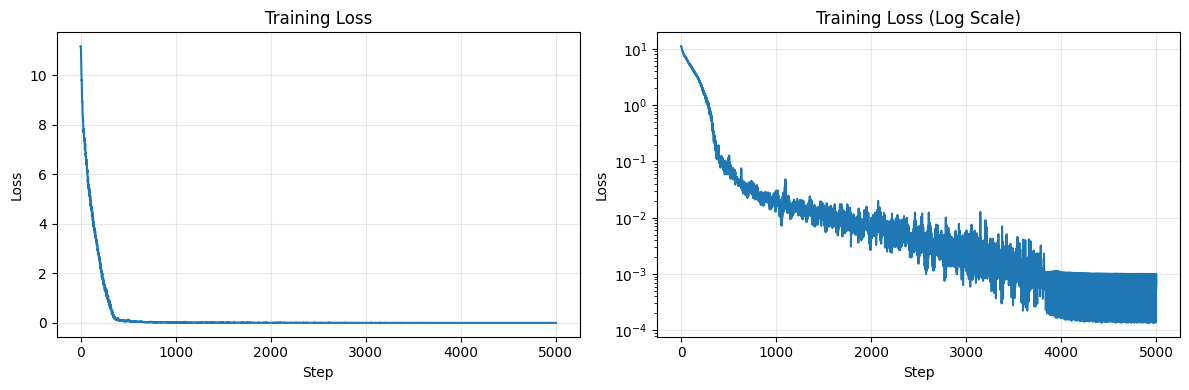


Loss Statistics:
  Starting loss: 11.1658
  Final loss: 0.0006
  Min loss: 0.0001


In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(loss_history)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True, alpha=0.3)

# Loss curve (log scale)
plt.subplot(1, 2, 2)
plt.plot(loss_history)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training Loss (Log Scale)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_loss.png', dpi=150)
plt.show()

print(f"\nLoss Statistics:")
print(f"  Starting loss: {loss_history[0]:.4f}")
print(f"  Final loss: {loss_history[-1]:.4f}")
print(f"  Min loss: {min(loss_history):.4f}")

## 12. STOP - Training Complete at 5000 Steps

**Now we will simulate stopping and resuming from checkpoint.**

In [21]:
print("="*60)
print("TRAINING STOPPED AT STEP 5000")
print("Simulating complete stop...")
print("="*60)

TRAINING STOPPED AT STEP 5000
Simulating complete stop...


## 13. Resume Training from Checkpoint

**Critical step for assignment**: Load checkpoint and continue training for 50 more steps.

In [22]:
# Create a fresh model and optimizer (simulating restart)
print("\n" + "="*60)
print("CREATING FRESH MODEL (simulating restart)")
print("="*60)

config_fresh = SmolLM2Config()
model_fresh = SmolLM2(config_fresh)
model_fresh.to(device)

# Compile if available
if device == 'cuda' and hasattr(torch, 'compile'):
    model_fresh = torch.compile(model_fresh)

optimizer_fresh = torch.optim.AdamW(
    model_fresh.parameters(),
    lr=max_lr,
    betas=(0.9, 0.95),
    eps=1e-8,
    weight_decay=weight_decay,
    fused=True if device == 'cuda' else False
)

print("Fresh model created.")


CREATING FRESH MODEL (simulating restart)
Fresh model created.


In [27]:
# Load checkpoint from step 5000
print("\n" + "="*60)
print("LOADING CHECKPOINT FROM STEP 5000")
print("="*60)

checkpoint_path = os.path.join(checkpoint_dir, 'checkpoint_step_5000.pt')
resume_step, resume_loss = load_checkpoint(model_fresh, optimizer_fresh, checkpoint_path, device)


LOADING CHECKPOINT FROM STEP 5000
Checkpoint loaded: checkpoints/checkpoint_step_5000.pt (step 5000, loss 0.0006)


In [28]:
# Continue training for 50 more steps
additional_steps = 50
total_steps_after_resume = resume_step + additional_steps

print("\n" + "="*60)
print(f"RESUMING TRAINING FROM STEP {resume_step} FOR {additional_steps} MORE STEPS")
print("="*60 + "\n")

loss_history_resumed = []
start_time_resumed = time.time()

for step in range(resume_step, total_steps_after_resume):
    # Update learning rate (continuing the schedule)
    lr = get_lr(step)
    for param_group in optimizer_fresh.param_groups:
        param_group['lr'] = lr

    # Gradient accumulation
    optimizer_fresh.zero_grad()
    loss_accum = 0.0

    for micro_step in range(gradient_accumulation_steps):
        x, y = train_loader.next_batch()
        x, y = x.to(device), y.to(device)

        with torch.autocast(device_type=device, dtype=torch.bfloat16):
            logits, loss = model_fresh(x, y)

        loss = loss / gradient_accumulation_steps
        loss_accum += loss.detach()
        loss.backward()

    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model_fresh.parameters(), max_norm=grad_clip)

    # Optimizer step
    optimizer_fresh.step()

    # Record loss
    loss_history_resumed.append(loss_accum.item())

    # Log every step for the resumed training
    print(f'Step {step + 1:5d}/{total_steps_after_resume} | Loss: {loss_accum.item():.4f} | LR: {lr:.2e}')

# Save final checkpoint
final_checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_step_{total_steps_after_resume}.pt')
save_checkpoint(model_fresh, optimizer_fresh, total_steps_after_resume, loss_accum.item(), final_checkpoint_path)

# Generate final samples
generate_samples(model_fresh, total_steps_after_resume, device)

elapsed_resumed = time.time() - start_time_resumed
print("\n" + "="*60)
print(f"RESUMED TRAINING COMPLETE")
print("="*60)
print(f"Trained from step {resume_step} to step {total_steps_after_resume}")
print(f"Final loss: {loss_accum.item():.4f}")
print(f"Time for {additional_steps} steps: {elapsed_resumed:.1f}s")


RESUMING TRAINING FROM STEP 5000 FOR 50 MORE STEPS

Step  5001/5050 | Loss: 0.0004 | LR: 6.00e-05
Step  5002/5050 | Loss: 0.0005 | LR: 6.00e-05
Step  5003/5050 | Loss: 0.0005 | LR: 6.00e-05
Step  5004/5050 | Loss: 0.0007 | LR: 6.00e-05
Step  5005/5050 | Loss: 0.0007 | LR: 6.00e-05
Step  5006/5050 | Loss: 0.0007 | LR: 6.00e-05
Step  5007/5050 | Loss: 0.0009 | LR: 6.00e-05
Step  5008/5050 | Loss: 0.0001 | LR: 6.00e-05
Step  5009/5050 | Loss: 0.0005 | LR: 6.00e-05
Step  5010/5050 | Loss: 0.0007 | LR: 6.00e-05
Step  5011/5050 | Loss: 0.0006 | LR: 6.00e-05
Step  5012/5050 | Loss: 0.0007 | LR: 6.00e-05
Step  5013/5050 | Loss: 0.0005 | LR: 6.00e-05
Step  5014/5050 | Loss: 0.0010 | LR: 6.00e-05
Step  5015/5050 | Loss: 0.0006 | LR: 6.00e-05
Step  5016/5050 | Loss: 0.0004 | LR: 6.00e-05
Step  5017/5050 | Loss: 0.0005 | LR: 6.00e-05
Step  5018/5050 | Loss: 0.0005 | LR: 6.00e-05
Step  5019/5050 | Loss: 0.0007 | LR: 6.00e-05
Step  5020/5050 | Loss: 0.0007 | LR: 6.00e-05
Step  5021/5050 | Loss: 0.0

## 14. Final Summary

In [29]:
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"\nModel: SmolLM2-135M")
print(f"Total Parameters: {total_params:,}")
print(f"\nTraining:")
print(f"  Initial training: 5000 steps")
print(f"  Resumed training: 50 steps (from checkpoint)")
print(f"  Total steps: 5050")
print(f"\nCheckpoints saved:")
for f in sorted(os.listdir(checkpoint_dir)):
    print(f"  - {f}")
print(f"\nSpeedups used:")
print(f"  - FlashAttention (scaled_dot_product_attention)")
print(f"  - Mixed precision (bfloat16)")
print(f"  - torch.compile (if available)")
print(f"  - TF32 precision")
print(f"  - Gradient accumulation ({gradient_accumulation_steps}x)")
print(f"  - Fused AdamW optimizer")


TRAINING SUMMARY

Model: SmolLM2-135M
Total Parameters: 135,178,560

Training:
  Initial training: 5000 steps
  Resumed training: 50 steps (from checkpoint)
  Total steps: 5050

Checkpoints saved:
  - checkpoint_step_1000.pt
  - checkpoint_step_1500.pt
  - checkpoint_step_2000.pt
  - checkpoint_step_2500.pt
  - checkpoint_step_3000.pt
  - checkpoint_step_3500.pt
  - checkpoint_step_4000.pt
  - checkpoint_step_4500.pt
  - checkpoint_step_500.pt
  - checkpoint_step_5000.pt
  - checkpoint_step_5050.pt

Speedups used:
  - FlashAttention (scaled_dot_product_attention)
  - Mixed precision (bfloat16)
  - torch.compile (if available)
  - TF32 precision
  - Gradient accumulation (4x)
  - Fused AdamW optimizer


## 15. Save Model for HuggingFace Spaces

In [30]:
# Save final model
model_to_save = model_fresh._orig_mod if hasattr(model_fresh, '_orig_mod') else model_fresh
torch.save({
    'model_state_dict': model_to_save.state_dict(),
    'config': config,
}, 'smollm2_135m_final.pt')
print("Final model saved to 'smollm2_135m_final.pt'")

Final model saved to 'smollm2_135m_final.pt'
